In [9]:
#!/usr/bin/env python

# Comarison_FireObs.ipynb

In [1]:
'''File name: Comarison_FireObs
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.06.2020
    Date last modified: 19.06.2020

    ############################################################## 
    Purpos:

    Read in daily burned area observations from different datasets
    
    Compare them with each other

'''

'File name: Comarison_FireObs\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 19.06.2020\n    Date last modified: 19.06.2020\n\n    ############################################################## \n    Purpos:\n\n    Read in daily burned area observations from different datasets\n    \n    Compare them with each other\n\n'

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata
from Functions_Extreme_WTs import ExtremeDays

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

### User setup area

In [3]:
CA_Regions=['Bay_Area','Central_Coast','LA','Modoc','Northeast','San_Diego','Siearas_East','Siearas_West']
sPlotDir='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/'# +str(iNrOfExtremes)+'_Events/'
sSubregion='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/Shapefiles/' #+Regions[sRegion]

ModisDataDir='/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/GriddedData/'
SheanDataDir='/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Sean_Parks/SubRegion_DailyBurnedArea/'

iMonths=range(1,13,1)

### Read in MODIS data and calcualte averages for subregions

In [4]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/data_20020702/GriddedData/MODIS_BA_GLOBAL_1_2016_01_gridded.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['rlat'][:])
rgrLonPR=np.squeeze(ncid.variables['rlon'][:])
ncid.close()

dStartDayPR=datetime.datetime(2001, 1, 1,0) # (2000, 11, 01,0)
dStopDayPR=datetime.datetime(2019, 11, 30,23)
rgdTimeMODIS = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
rgdTimeMM = pd.date_range(dStartDayPR, end=dStopDayPR, freq='m')

MODIS_SRdata=np.zeros((len(rgdTimeMODIS),len(CA_Regions))); MODIS_SRdata[:]=np.nan

for sr in range(len(CA_Regions)):
    print('    process MODIS for region '+CA_Regions[sr])
    sSubregionPR=sSubregion+CA_Regions[sr]

    rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
    rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
        rgrSRactP[TMP == 1]=1
    rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))
    
    rgiSrPR=np.array(np.where(rgrSRactP == True))
    iLatMaxP=rgiSrPR[0,:].max()+1
    iLatMinP=rgiSrPR[0,:].min()
    iLonMaxP=rgiSrPR[1,:].max()+1
    iLonMinP=rgiSrPR[1,:].min()
    rgrPRdata=np.zeros((len(rgdTimeMODIS),iLatMaxP-iLatMinP,iLonMaxP-iLonMinP))

    for mo in range(len(rgdTimeMM)):
        rgiDD=np.where(((rgdTimeMM.year[mo] == rgdTimeMODIS.year) & (rgdTimeMODIS.month == rgdTimeMM.month[mo]) & np.isin(rgdTimeMM.month[mo], iMonths)))[0]
        ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/data_20020702/GriddedData/MODIS_BA_GLOBAL_1_'+str(rgdTimeMM.year[mo])+'_'+str("%02d" % rgdTimeMM.month[mo])+'_gridded.nc', mode='r')
        rgrPRdata[rgiDD,:,:]=np.squeeze(ncid.variables['BurnedArea'][:,iLatMinP:iLatMaxP,iLonMinP:iLonMaxP])
        ncid.close()
    rgrPRdata[rgrPRdata<0] = np.nan
    MODIS_SRdata[:,sr]=np.nansum(rgrPRdata, axis = (1,2))

    process MODIS for region Bay_Area
    process MODIS for region Central_Coast
    process MODIS for region LA
    process MODIS for region Modoc
    process MODIS for region Northeast
    process MODIS for region San_Diego
    process MODIS for region Siearas_East
    process MODIS for region Siearas_West


### Read in Shean Parks' dataset

In [5]:
# Ming processed this data!
dStartDayPR=datetime.datetime(2002, 1, 1,0) # (2000, 11, 01,0)
dStopDayPR=datetime.datetime(2018, 12, 31,23)
rgdTimeParks = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')

Parks_SRdata=np.zeros((len(rgdTimeParks),len(CA_Regions))); Parks_SRdata[:]=np.nan
for sr in range(len(CA_Regions)):
    print('    process Parks\' data for region '+CA_Regions[sr])
    FILE=SheanDataDir+CA_Regions[sr]+'.txt'
    Parks_SRdata[:,sr]=np.array(pd.read_csv(FILE, delim_whitespace=True, header = None))[:,0]

    process Parks' data for region Bay_Area
    process Parks' data for region Central_Coast
    process Parks' data for region LA
    process Parks' data for region Modoc
    process Parks' data for region Northeast
    process Parks' data for region San_Diego
    process Parks' data for region Siearas_East
    process Parks' data for region Siearas_West


### Read MTBS_CA_1984_2016.csv

In [6]:
StartTime=datetime.datetime(1984, 1, 1)  #Y-M-D --> days are smallest possible period
StopTime=datetime.datetime(2016, 12, 31)
rgdTimeMTBS = pd.date_range(StartTime, end=StopTime, freq='d')
rgiYearsMTPS=np.unique(rgdTimeMTBS.year)

sFireData='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/data/MTBS_CA_1984_2016.csv'
sSaveDataDir='/glade/work/prein/projects/2019_Janice-CA-Fire-WTs/data/'

DATA=pd.read_csv(sFireData)
Keys=DATA.keys()
lat=np.array(DATA['lat16'])
lon=np.array(DATA['lon16'])
YYYY=np.array(DATA['FIRE_YEAR'])
MM=np.array(DATA['FIRE_MON'])
DD=np.array(DATA['FIRE_DAY'])
FireID=np.array(DATA['FIRE_ID'])
AcresBurned=np.array(DATA['R_ACRES'])*0.00404686

MTBS_SRdata=np.zeros((len(rgdTimeMTBS),len(CA_Regions))); MTBS_SRdata[:]=0
for sr in range(len(CA_Regions)):
    print('    process MTBS data for region '+CA_Regions[sr])
    sSubregionPR=sSubregion+CA_Regions[sr]

    rgrGridCells=[(lon.ravel()[ii],lat.ravel()[ii]) for ii in range(len(lon.ravel()))]
    rgrSRactP=np.zeros((lon.shape[0]))
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
        rgrSRactP[TMP == 1]=1
    LONact=lon[rgrSRactP == 1]
    LATact=lat[rgrSRactP == 1]
    BURNEDact=AcresBurned[rgrSRactP == 1]
    MMact=MM[rgrSRactP == 1]
    YYYYact=YYYY[rgrSRactP == 1]
    DDact=DD[rgrSRactP == 1]
    for fi in range(len(YYYYact)):
        DDid=((rgdTimeMTBS.year == YYYYact[fi]) & (rgdTimeMTBS.month == MMact[fi]) & (rgdTimeMTBS.day == DDact[fi]))
        MTBS_SRdata[DDid,sr]=BURNEDact[fi]

    process MTBS data for region Bay_Area
    process MTBS data for region Central_Coast
    process MTBS data for region LA
    process MTBS data for region Modoc
    process MTBS data for region Northeast
    process MTBS data for region San_Diego
    process MTBS data for region Siearas_East
    process MTBS data for region Siearas_West


### Read FIRMS_MODIS-C6

In [7]:
Data1 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_MODIS-C6/fire_archive_M6_7667.csv'
Data2 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_MODIS-C6/fire_nrt_M6_7667.csv'

dStartDayPR=datetime.datetime(2000, 1, 1,0) # (2000, 11, 01,0)
dStopDayPR=datetime.datetime(2020, 9, 30,23)
rgdTimeFIRMS_M = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
rgdTimeMM = pd.date_range(dStartDayPR, end=dStopDayPR, freq='m')

DATA1 = pd.read_csv(Data1)
DATA2 = pd.read_csv(Data2)

LAT_FM = np.append(np.array(DATA1['latitude']),np.array(DATA2['latitude']))
LON_FM = np.append(np.array(DATA1['longitude']),np.array(DATA2['longitude']))
DATE_FM = np.append(np.array(DATA1['acq_date']),np.array(DATA2['acq_date']))
AREA_FM = np.append(np.array(DATA1['scan'])*np.array(DATA1['track']),np.array(DATA2['scan'])*np.array(DATA2['track']))

# Cut out CA region
CA = ((LAT_FM >= 32) & (LAT_FM <= 42) & (LON_FM >= -125) & (LON_FM <=- 114))
LAT_FM = LAT_FM[CA]
LON_FM = LON_FM[CA]
DATE_FM = DATE_FM[CA]
AREA_FM = AREA_FM[CA]

FIRMSM_SRdata=np.zeros((len(rgdTimeFIRMS_M),len(CA_Regions))); FIRMSM_SRdata[:]=0
for sr in range(len(CA_Regions)):
    print('    process MODIS data for region '+CA_Regions[sr])
    sSubregionPR=sSubregion+CA_Regions[sr]
    rgrGridCells=[(LON_FM.ravel()[ii],LAT_FM.ravel()[ii]) for ii in range(len(LON_FM.ravel()))]
    rgrSRactP=np.zeros((LON_FM.shape[0]))
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
    DATE_SR = DATE_FM[TMP == 1]
    AREA_SR = AREA_FM[TMP == 1]
    DAYS_act = np.unique(DATE_SR)
    for dd in range(len(DAYS_act)):
        iDD = ((rgdTimeFIRMS_M.year == int(DAYS_act[dd][:4])) & (rgdTimeFIRMS_M.month == int(DAYS_act[dd][5:7])) & (rgdTimeFIRMS_M.day == int(DAYS_act[dd][8:10])))
        Events = (DAYS_act[dd] == DATE_SR)
        FIRMSM_SRdata[iDD,sr] = np.sum(AREA_SR[Events])

    process MODIS data for region Bay_Area
    process MODIS data for region Central_Coast
    process MODIS data for region LA
    process MODIS data for region Modoc
    process MODIS data for region Northeast
    process MODIS data for region San_Diego
    process MODIS data for region Siearas_East
    process MODIS data for region Siearas_West


Text(0.5, 1.0, 'Siearas_West')

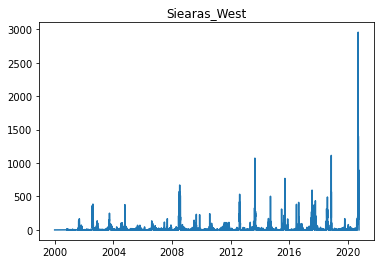

In [16]:
re = 7
plt.plot(rgdTimeFIRMS_M,FIRMSM_SRdata[:,re])
plt.title(CA_Regions[re])

### Read FIRMS_VIIRS

In [8]:
Data1 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_VIIRS/fire_archive_V1_7669.csv'
Data2 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_VIIRS/fire_nrt_V1_7669.csv'

dStartDayPR=datetime.datetime(2012, 1, 1,0) # (2000, 11, 01,0)
dStopDayPR=datetime.datetime(2020, 9, 30,23)
rgdTimeFIRMS_V = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
rgdTimeMM = pd.date_range(dStartDayPR, end=dStopDayPR, freq='m')

DATA1 = pd.read_csv(Data1)
DATA2 = pd.read_csv(Data2)

LAT_FV = np.append(np.array(DATA1['latitude']),np.array(DATA2['latitude']))
LON_FV = np.append(np.array(DATA1['longitude']),np.array(DATA2['longitude']))
DATE_FV = np.append(np.array(DATA1['acq_date']),np.array(DATA2['acq_date']))
AREA_FV = np.append(np.array(DATA1['scan'])*np.array(DATA1['track']),np.array(DATA2['scan'])*np.array(DATA2['track']))

# Cut out CA region
CA = ((LAT_FV >= 32) & (LAT_FV <= 42) & (LON_FV >= -125) & (LON_FV <=- 114))
LAT_FV = LAT_FV[CA]
LON_FV = LON_FV[CA]
DATE_FV = DATE_FV[CA]
AREA_FV = AREA_FV[CA]

FIRMSV_SRdata=np.zeros((len(rgdTimeFIRMS_V),len(CA_Regions))); FIRMSV_SRdata[:]=0
for sr in range(len(CA_Regions)):
    print('    process VIIRS data for region '+CA_Regions[sr])
    sSubregionPR=sSubregion+CA_Regions[sr]
    rgrGridCells=[(LON_FV.ravel()[ii],LAT_FV.ravel()[ii]) for ii in range(len(LON_FV.ravel()))]
    rgrSRactP=np.zeros((LON_FV.shape[0]))
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
    DATE_SR = DATE_FV[TMP == 1]
    AREA_SR = AREA_FV[TMP == 1]
    DAYS_act = np.unique(DATE_SR)
    for dd in range(len(DAYS_act)):
        iDD = ((rgdTimeFIRMS_V.year == int(DAYS_act[dd][:4])) & (rgdTimeFIRMS_V.month == int(DAYS_act[dd][5:7])) & (rgdTimeFIRMS_V.day == int(DAYS_act[dd][8:10])))
        Events = (DAYS_act[dd] == DATE_SR)
        FIRMSV_SRdata[iDD,sr] = np.sum(AREA_SR[Events])

    process VIIRS data for region Bay_Area
    process VIIRS data for region Central_Coast
    process VIIRS data for region LA
    process VIIRS data for region Modoc
    process VIIRS data for region Northeast
    process VIIRS data for region San_Diego
    process VIIRS data for region Siearas_East
    process VIIRS data for region Siearas_West


### Calculate the percent of annual burned area during top x days

In [30]:
xDays = 7
# sDatasets = ['VIIRS', 'MODIS','GWIS'] # ,'Parks'
# Data = [FIRMSV_SRdata, FIRMSM_SRdata, MODIS_SRdata] #, Parks_SRdata

sDatasets = ['VIIRS'] # ,'Parks'
Data = [FIRMSV_SRdata[rgdTimeFIRMS_V.year == 2020,:]]

FinData = np.zeros((len(sDatasets),len(CA_Regions)))
for da in range(len(Data)):
    print(sDatasets[da])
    DataAct = Data[da]
#     xDays = int((len(DataAct)/100)*1)
    print(xDays)
    for sr in range(len(CA_Regions)):
#         iTTex=ExtremeDays(DataAct[:,sr],xDays,7)
        iTTex=np.argsort(DataAct[:,sr])[-xDays:]
        print('    '+str(np.round((np.sum(DataAct[iTTex,sr])/np.sum(DataAct[:,sr]))*100.,1))+ ' - ' +CA_Regions[sr])
        FinData[da,sr] = np.round((np.sum(DataAct[iTTex,sr])/np.sum(DataAct[:,sr]))*100.,1)

VIIRS
7
    81.5 - Bay_Area
    57.7 - Central_Coast
    42.5 - LA
    51.2 - Modoc
    40.9 - Northeast
    56.0 - San_Diego
    59.2 - Siearas_East
    45.2 - Siearas_West


In [49]:
np.mean(FinData, axis=0)

array([68.9       , 48.43333333, 50.53333333, 56.9       , 34.6       ,
       76.83333333, 59.63333333, 35.23333333])

In [50]:
np.std(FinData, axis=0)

array([ 6.71466058,  6.02457928, 11.10685474,  2.98105127,  5.96042504,
       18.5005105 , 14.87286866,  4.4619378 ])

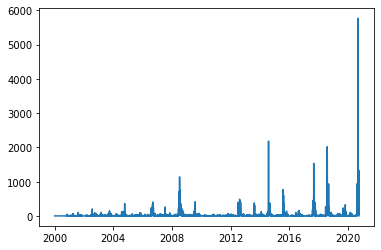

In [71]:
plt.plot(rgdTimeFIRMS_M[:],FIRMSM_SRdata[:,4])

2020-08-19 00:00:00


Text(0.5, 0, 'time [days]')

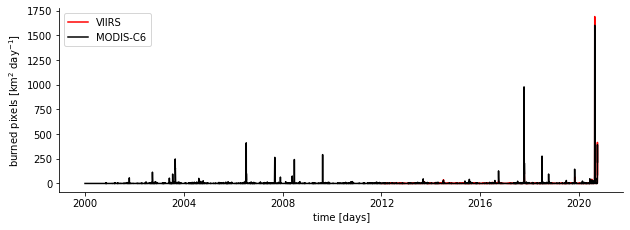

In [10]:
fig = plt.figure(figsize=(9,3))
t1 = 0 #-30
t2 = -1
re=0

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.08, right=0.95,
           bottom=0.10, top=0.95,
           wspace=0.15, hspace=0.70)

ax = plt.subplot(gs1[0,0])

plt.plot(rgdTimeFIRMS_V[t1:t2],FIRMSV_SRdata[t1:t2,re], c='r', label='VIIRS')
plt.plot(rgdTimeFIRMS_M[t1:t2],FIRMSM_SRdata[t1:t2,re], c='k', label='MODIS-C6')
print(rgdTimeFIRMS_V[np.argmax(FIRMSV_SRdata[t1:t2,re])])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend()

ax.set_ylabel('burned pixels [km$^{2}$ day$^{-1}$]')
ax.set_xlabel('time [days]')

2399954

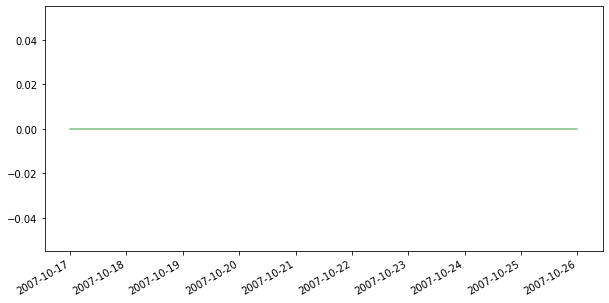

In [14]:
# Which Fire Zoom
fig = plt.figure(figsize=(10,5))
sr=5
MODISfocus=((rgdTimeMODIS.year==2007) & (rgdTimeMODIS.month == 10))
plt.plot(rgdTimeMODIS[MODISfocus][-15:-5], MODIS_SRdata[:,sr][MODISfocus][-15:-5], c='k', lw = 3)
Parksfocus=((rgdTimeParks.year==2007) & (rgdTimeParks.month == 10))
plt.plot(rgdTimeParks[Parksfocus][-15:-5], Parks_SRdata[:,sr][Parksfocus][-15:-5], c='r', alpha=0.5)
MTBSfocus=((rgdTimeMTBS.year==2007) & (rgdTimeMTBS.month == 10))
plt.plot(rgdTimeMTBS[MTBSfocus][-15:-5], MTBS_SRdata[:,sr][MTBSfocus][-15:-5], c='b', alpha=0.5)
FIRMSMfocus=((rgdTimeFIRMS_M.year==2007) & (rgdTimeFIRMS_M.month == 10))
plt.plot(rgdTimeFIRMS_M[FIRMSMfocus][-15:-5], FIRMSM_SRdata[:,sr][FIRMSMfocus][-15:-5], c='y', alpha=0.5)
FIRMSVfocus=((rgdTimeFIRMS_V.year==2007) & (rgdTimeFIRMS_V.month == 10))
plt.plot(rgdTimeFIRMS_V[FIRMSVfocus][-15:-5], FIRMSV_SRdata[:,sr][FIRMSVfocus][-15:-5], c='g', alpha=0.5)
fig.autofmt_xdate()

In [9]:
MTBS_SRdata[:,sr][MTBSfocus][-15:-5]

array([  0.        ,   0.        ,   0.        ,   0.        ,
       678.07850696,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

In [10]:
rgdTimeMTBS[MTBSfocus][-15:-5]

DatetimeIndex(['2007-10-17', '2007-10-18', '2007-10-19', '2007-10-20',
               '2007-10-21', '2007-10-22', '2007-10-23', '2007-10-24',
               '2007-10-25', '2007-10-26'],
              dtype='datetime64[ns]', freq='D')

In [11]:
rgdTimeParks[Parksfocus][-15:-5]

DatetimeIndex(['2007-10-17', '2007-10-18', '2007-10-19', '2007-10-20',
               '2007-10-21', '2007-10-22', '2007-10-23', '2007-10-24',
               '2007-10-25', '2007-10-26'],
              dtype='datetime64[ns]', freq='D')

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Peak-Fire-Days_LA_top3.pdf


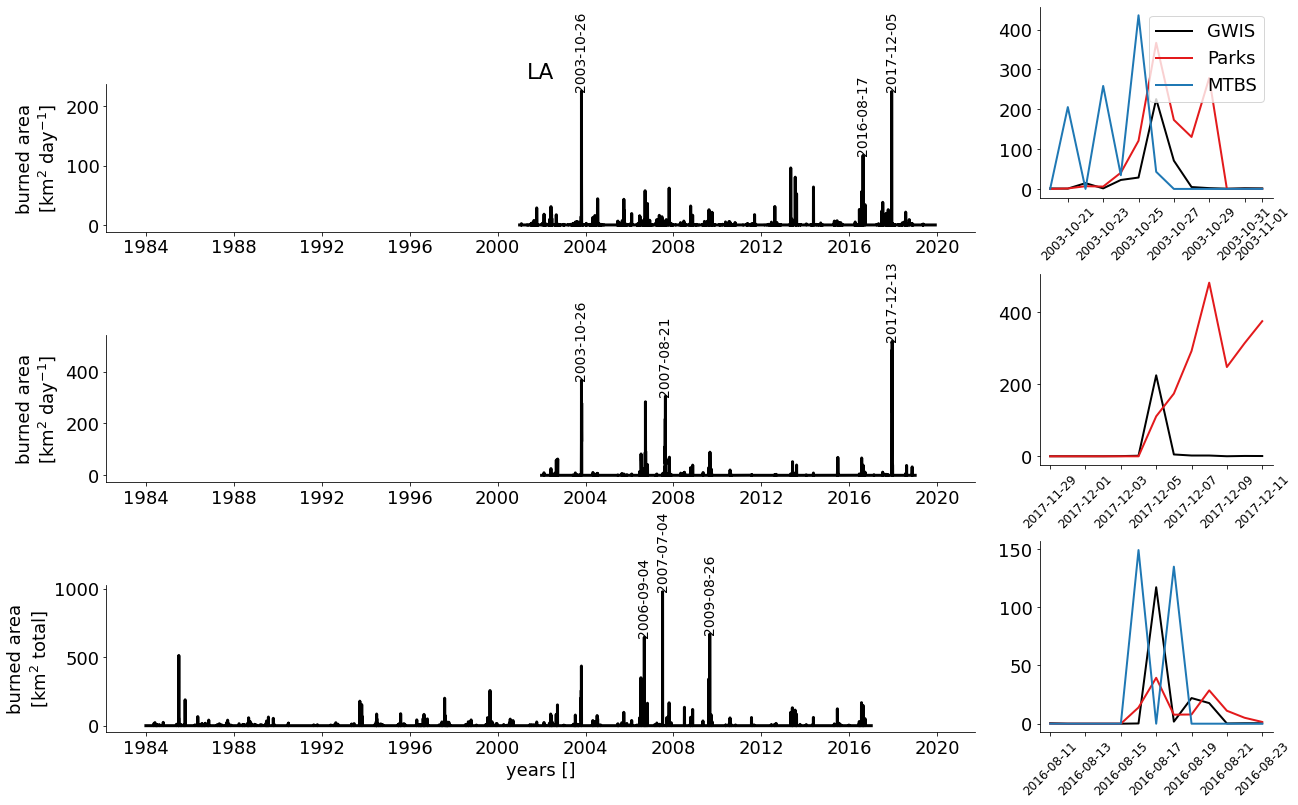

In [16]:
# join data into common matrix
sr=2
StartTime=datetime.datetime(1984, 1, 1)  #Y-M-D --> days are smallest possible period
StopTime=datetime.datetime(2019, 11, 30)
rgdTimeALL = pd.date_range(StartTime, end=StopTime, freq='d')
DATA_all=np.zeros((len(rgdTimeALL),3)); DATA_all[:]=np.nan
SelTime=((rgdTimeALL.year >= rgdTimeMODIS.year[0]) & (rgdTimeALL.year <= rgdTimeMODIS.year[-1]))
DATA_all[SelTime,0]=MODIS_SRdata[:,sr]
SelTime=((rgdTimeALL.year >= rgdTimeParks.year[0]) & (rgdTimeALL.year <= rgdTimeParks.year[-1]))
DATA_all[SelTime,1]=Parks_SRdata[:,sr]
SelTime=((rgdTimeALL.year >= rgdTimeMTBS.year[0]) & (rgdTimeALL.year <= rgdTimeMTBS.year[-1]))
DATA_all[SelTime,2]=MTBS_SRdata[:,sr]
DATA_all[0,:]=0; DATA_all[-1,:]=0

Labels=['GWIS','Parks','MTBS']

# save the data for use in other programs
File=CA_Regions[sr]+'_Fire-Obs.npz'
np.savez(File,
       DATA_all = DATA_all,
       rgdTimeALL = rgdTimeALL,
       sDataset = Labels)

plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(18,12))
gs1 = gridspec.GridSpec(3,1)
gs1.update(left=0.08, right=0.75,
           bottom=0.10, top=0.85,
           wspace=0.15, hspace=0.70)

for da in range(3):
    ax = plt.subplot(gs1[da,0])
    plt.plot(rgdTimeALL, DATA_all[:,da], c='k', lw = 3)

    # label three biggest days
    FIN=~np.isnan(DATA_all[:,da])
    iTTex=ExtremeDays(DATA_all[:,da][FIN],3,7)
    TopDates=rgdTimeALL[FIN][ExtremeDays(DATA_all[:,da][FIN],3,7)]
    for ex in range(len(iTTex)):
        plt.text(rgdTimeALL[FIN][iTTex[ex]], DATA_all[:,da][FIN][iTTex[ex]],\
                 str(TopDates[ex])[:10], va='bottom', ha='center', rotation=90, fontsize=14)
    if da < 2:
        ax.set_ylabel('burned area\n[km$^{2}$ day$^{-1}$]')
    else:
        ax.set_ylabel('burned area\n[km$^{2}$ total]')
    if da == 2:
        ax.set_xlabel('years []')
    if da == 0:
        plt.title(CA_Regions[sr])
        FinTopDates=TopDates
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


# Add zoom at top 3 fires
gs2 = gridspec.GridSpec(3,1)
gs2.update(left=0.80, right=0.98,
           bottom=0.10, top=0.94,
           wspace=0.25, hspace=0.40)
COLORS=['k','#e31a1c','#1f78b4']
for ex in range(len(TopDates[:3])):
    ax = plt.subplot(gs2[ex,0])
    iDD=np.where((rgdTimeALL.year == FinTopDates[ex].year) & (rgdTimeALL.month == FinTopDates[ex].month) & (rgdTimeALL.day == FinTopDates[ex].day))[0][0]
    DeltaD=6
    for da in range(3):
        plt.plot(rgdTimeALL[iDD-DeltaD:iDD+DeltaD+1],DATA_all[:,da][iDD-DeltaD:iDD+DeltaD+1],c=COLORS[da], label=Labels[da], lw=2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks(rotation=45, fontsize=12)
    if ex == 0:
        plt.legend()


sPlotFile='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/'
sPlotName= 'Peak-Fire-Days_'+CA_Regions[sr]+'_top3.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)
# fig.savefig(sPlotFile+sPlotName, dpi=700)

### Identify Peaks for Janice

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Peak-Fire-Days_Bay_Area.pdf
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Peak-Fire-Days_Central_Coast.pdf
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Peak-Fire-Days_LA.pdf
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Peak-Fire-Days_Modoc.pdf
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Peak-Fire-Days_Northeast.pdf
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Peak-Fire-Days_San_Diego.pdf
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Peak-Fire-Days_Siearas_East.pdf
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/Pe

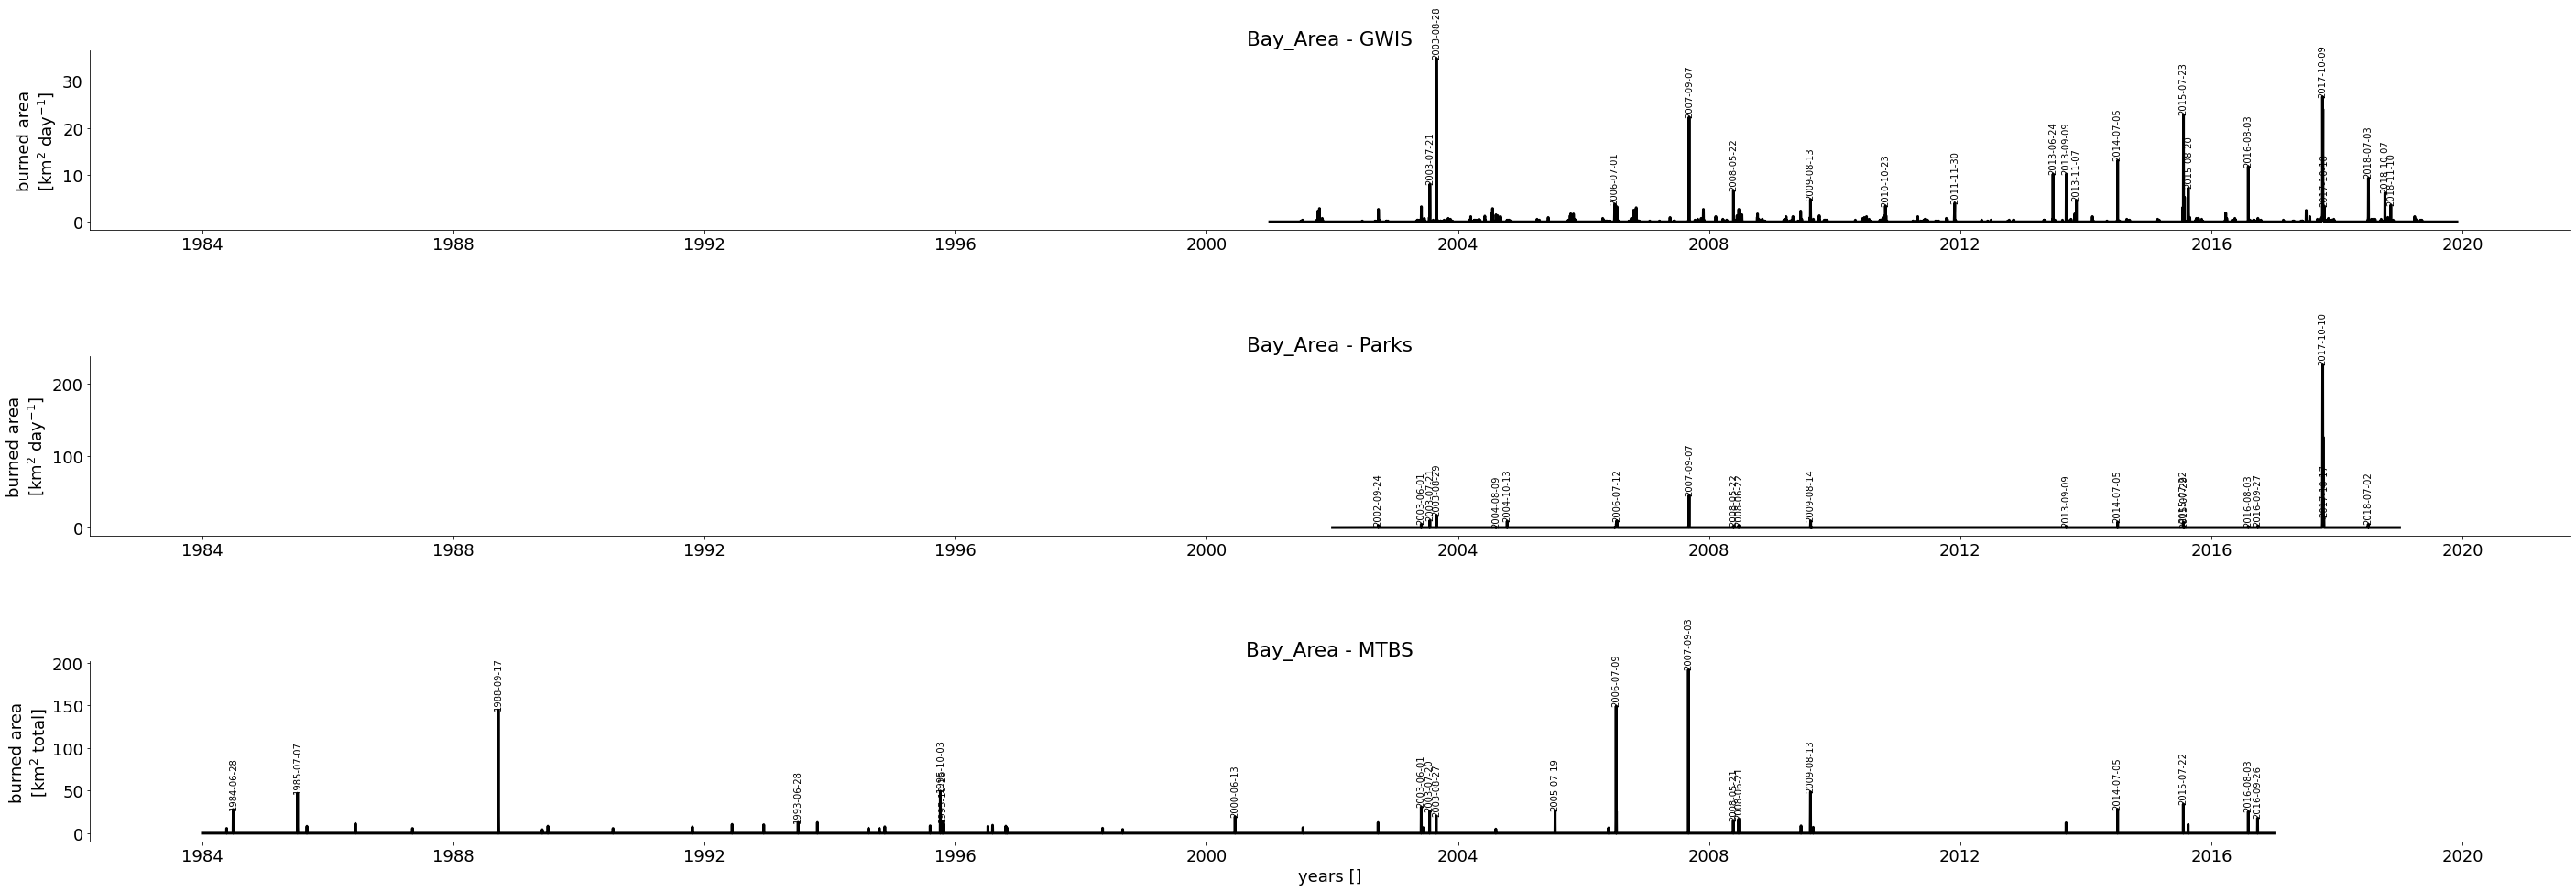

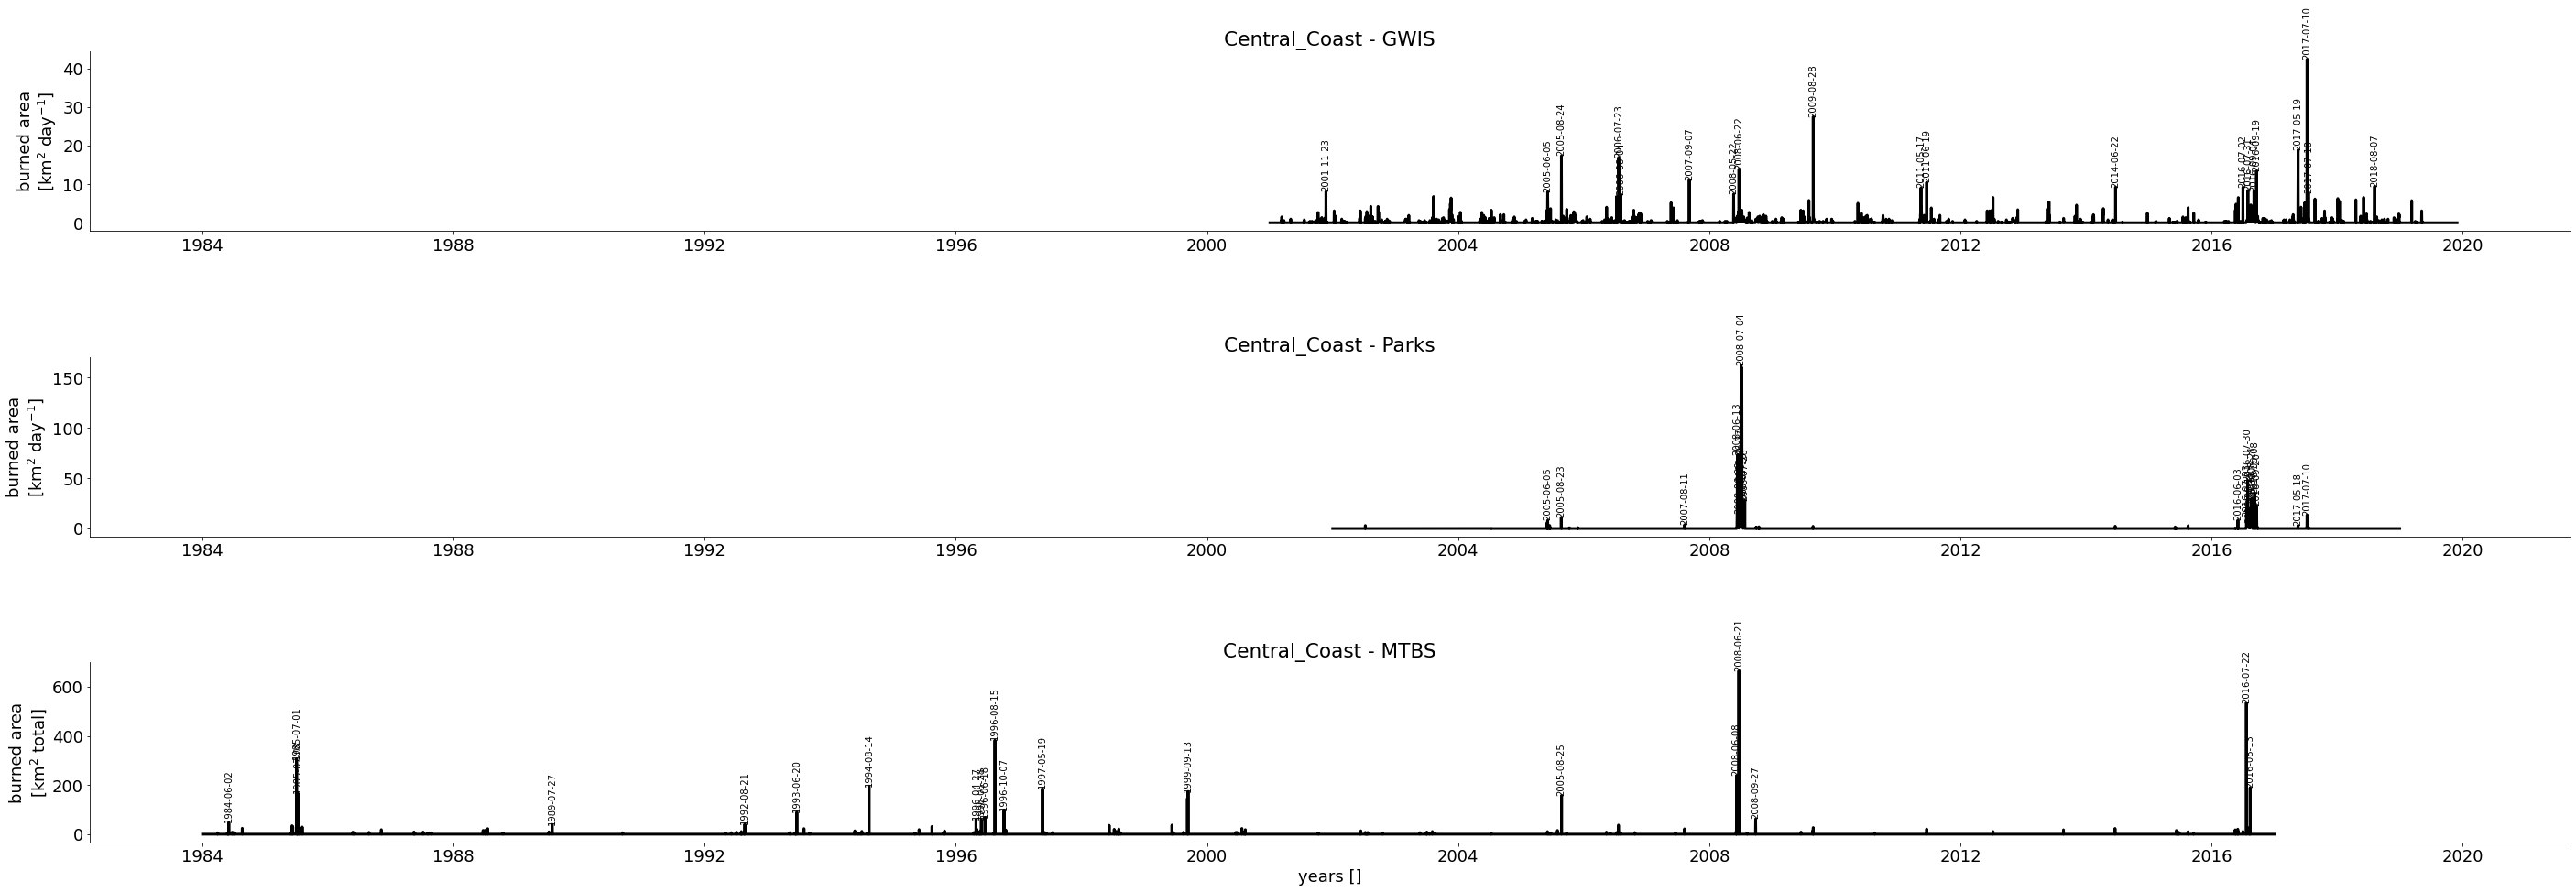

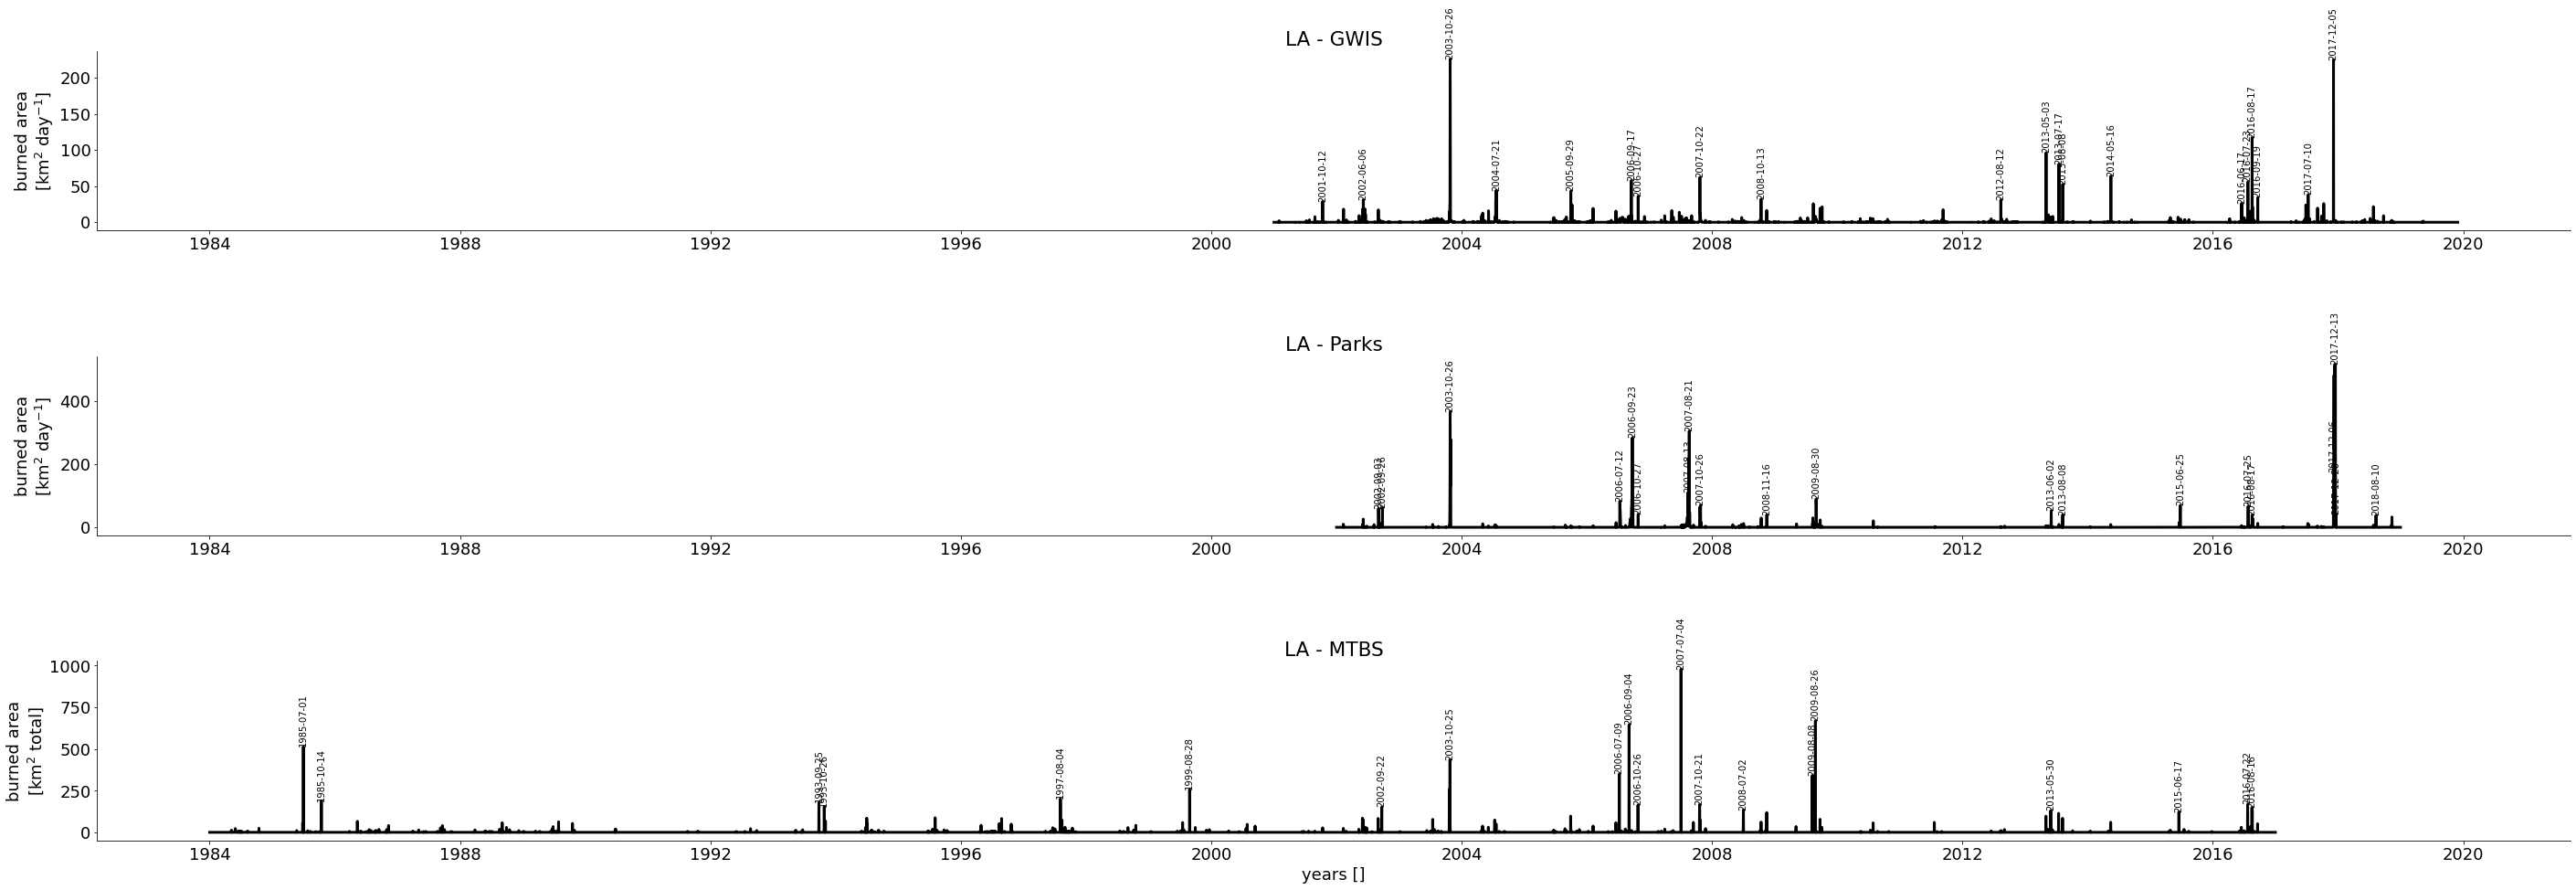

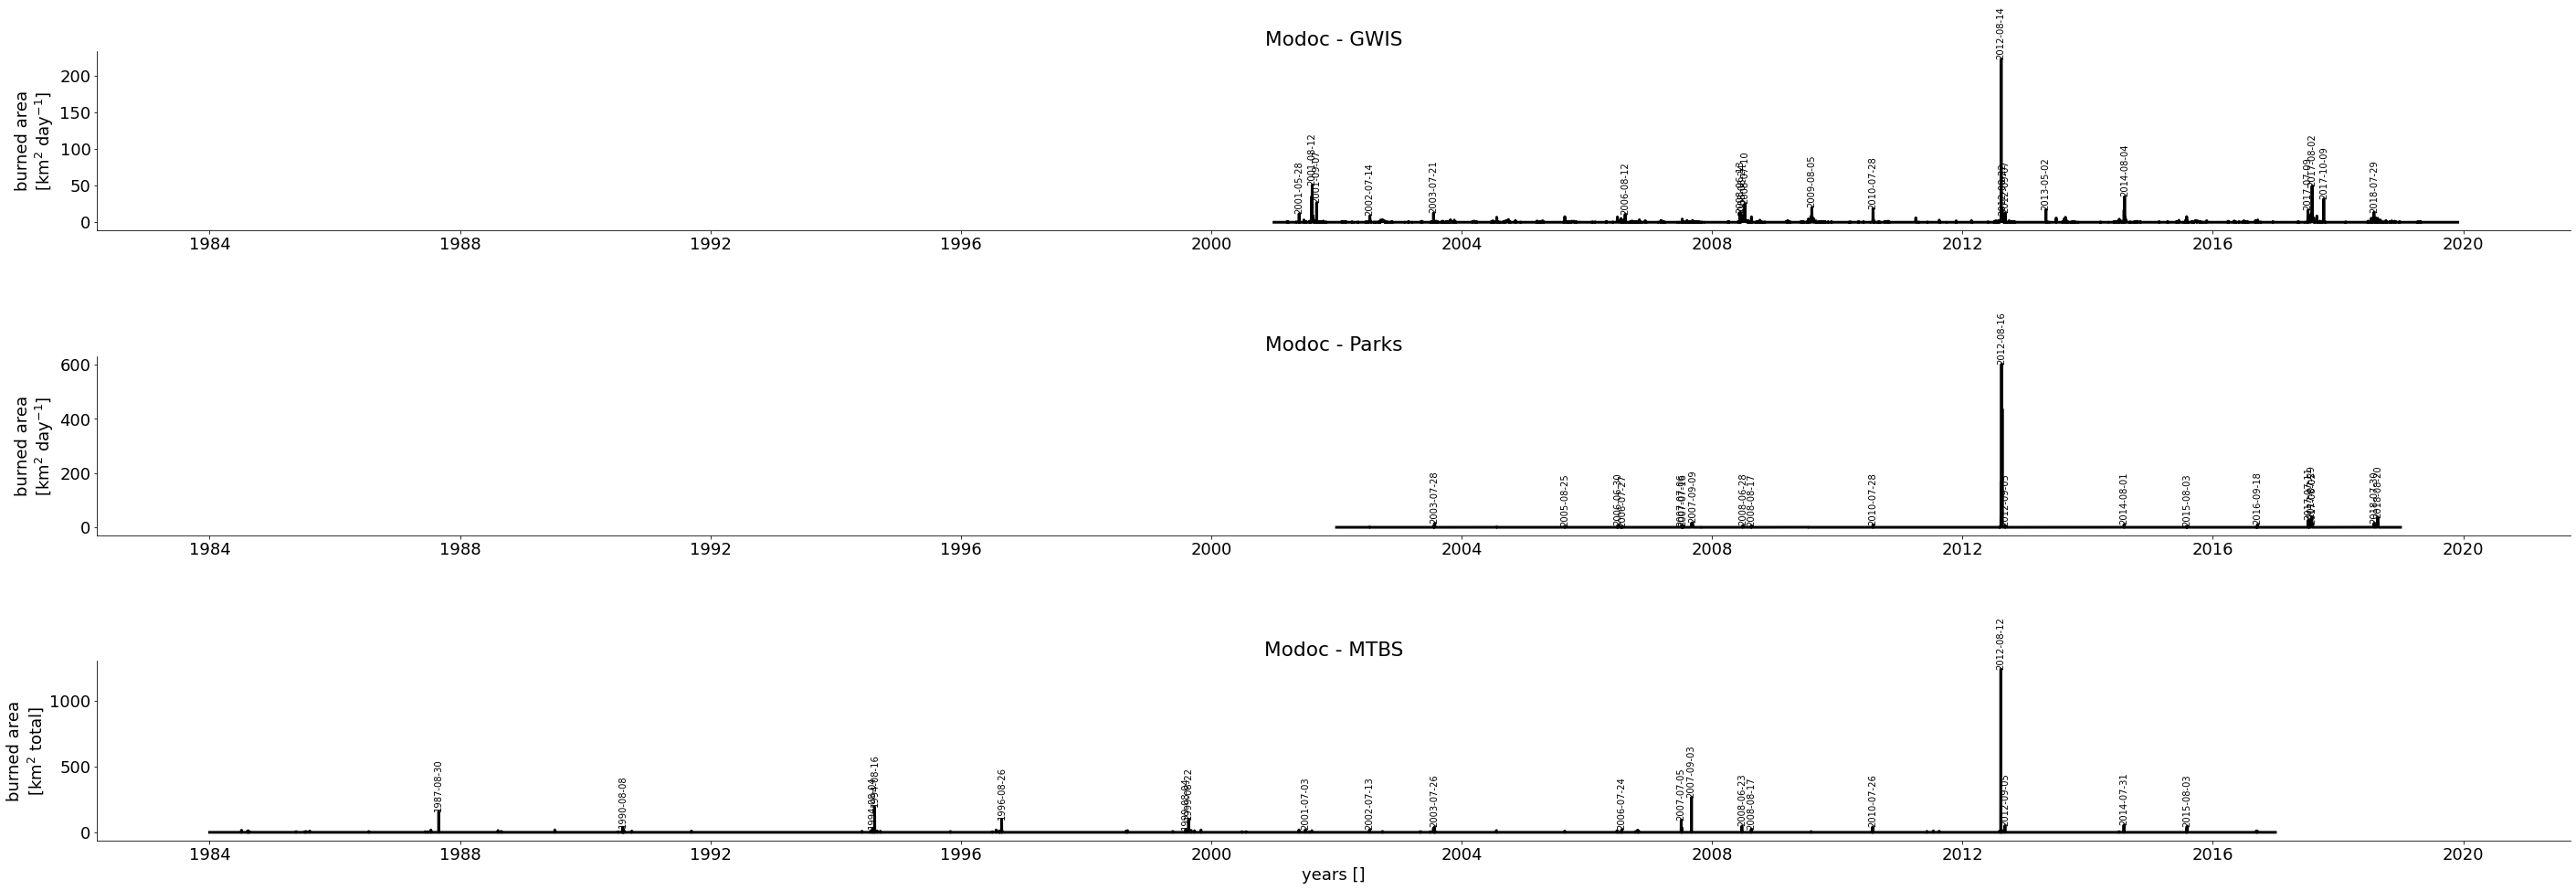

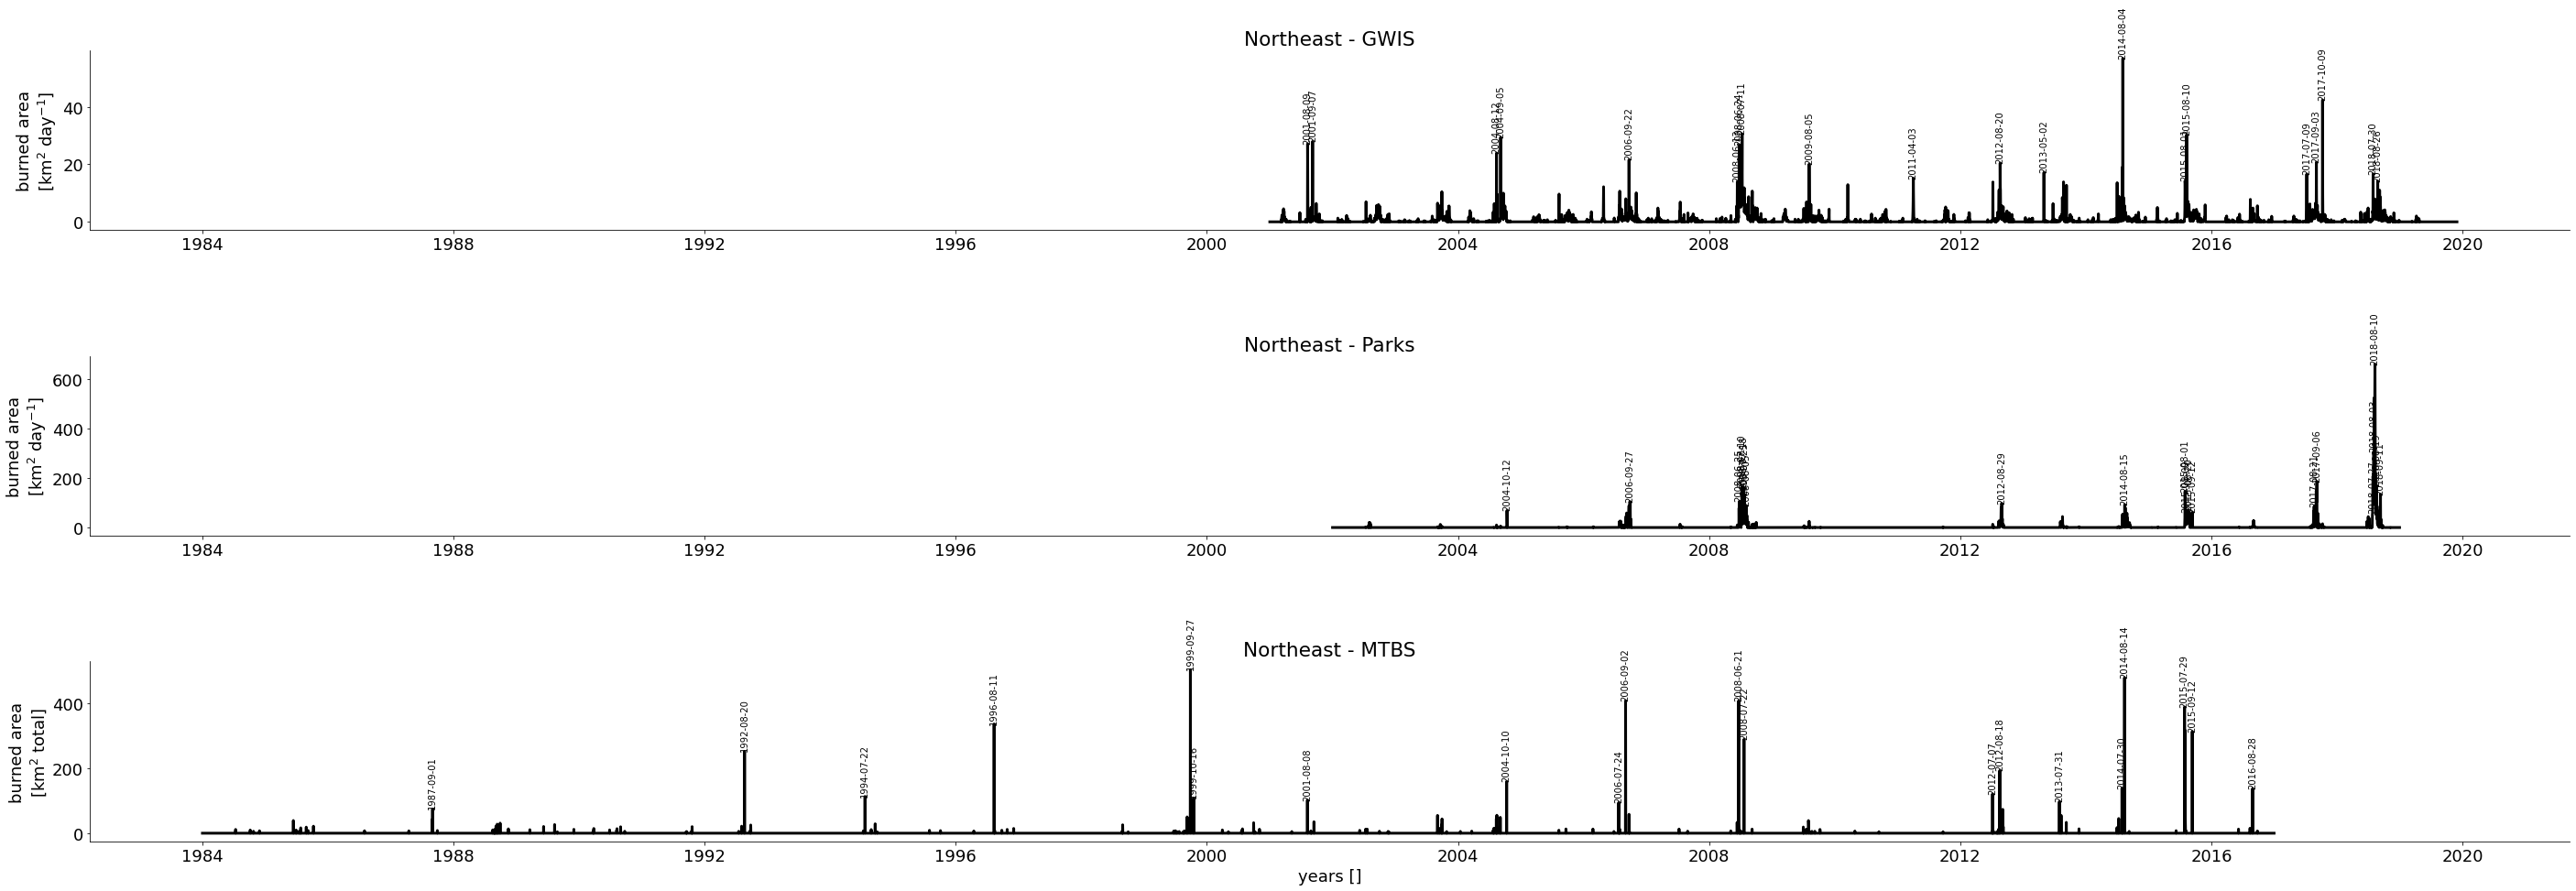

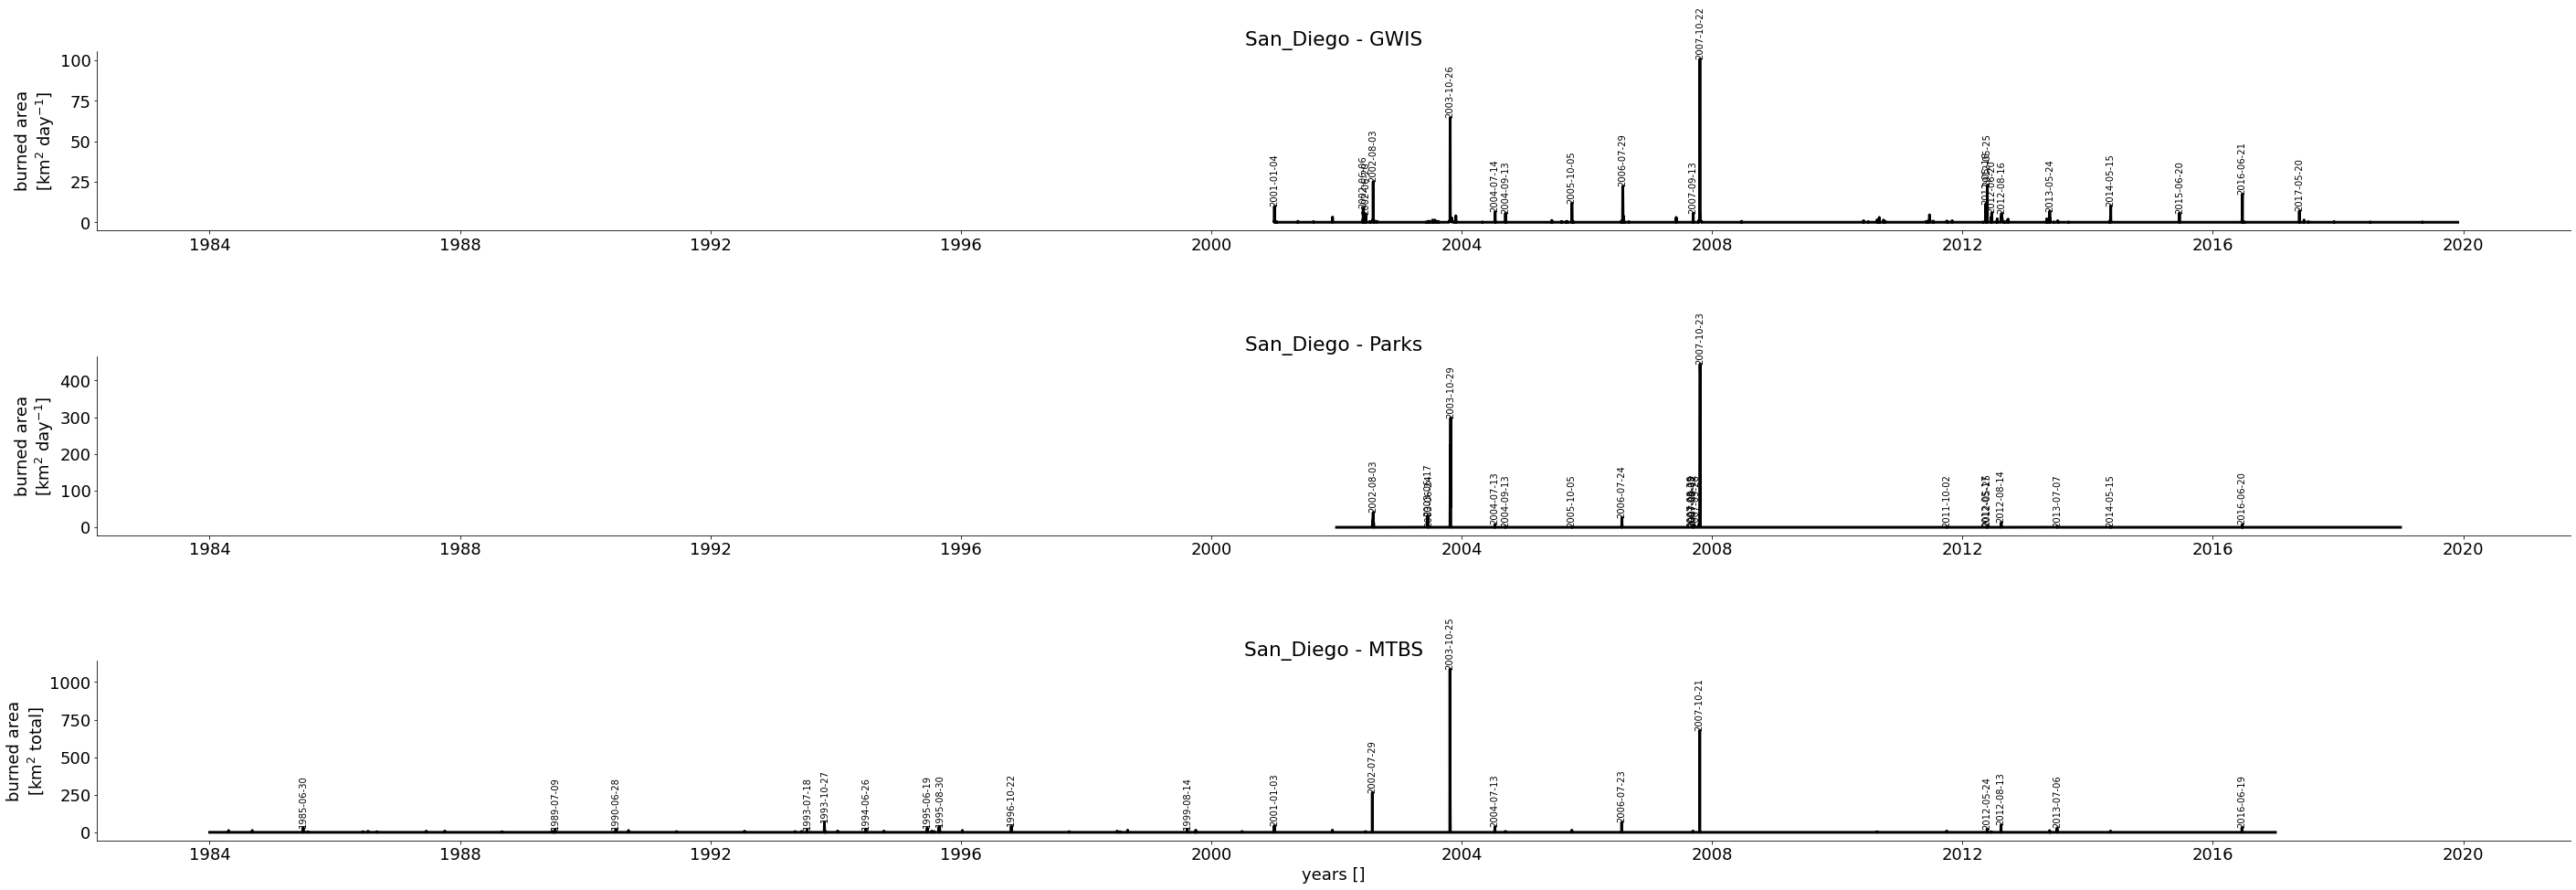

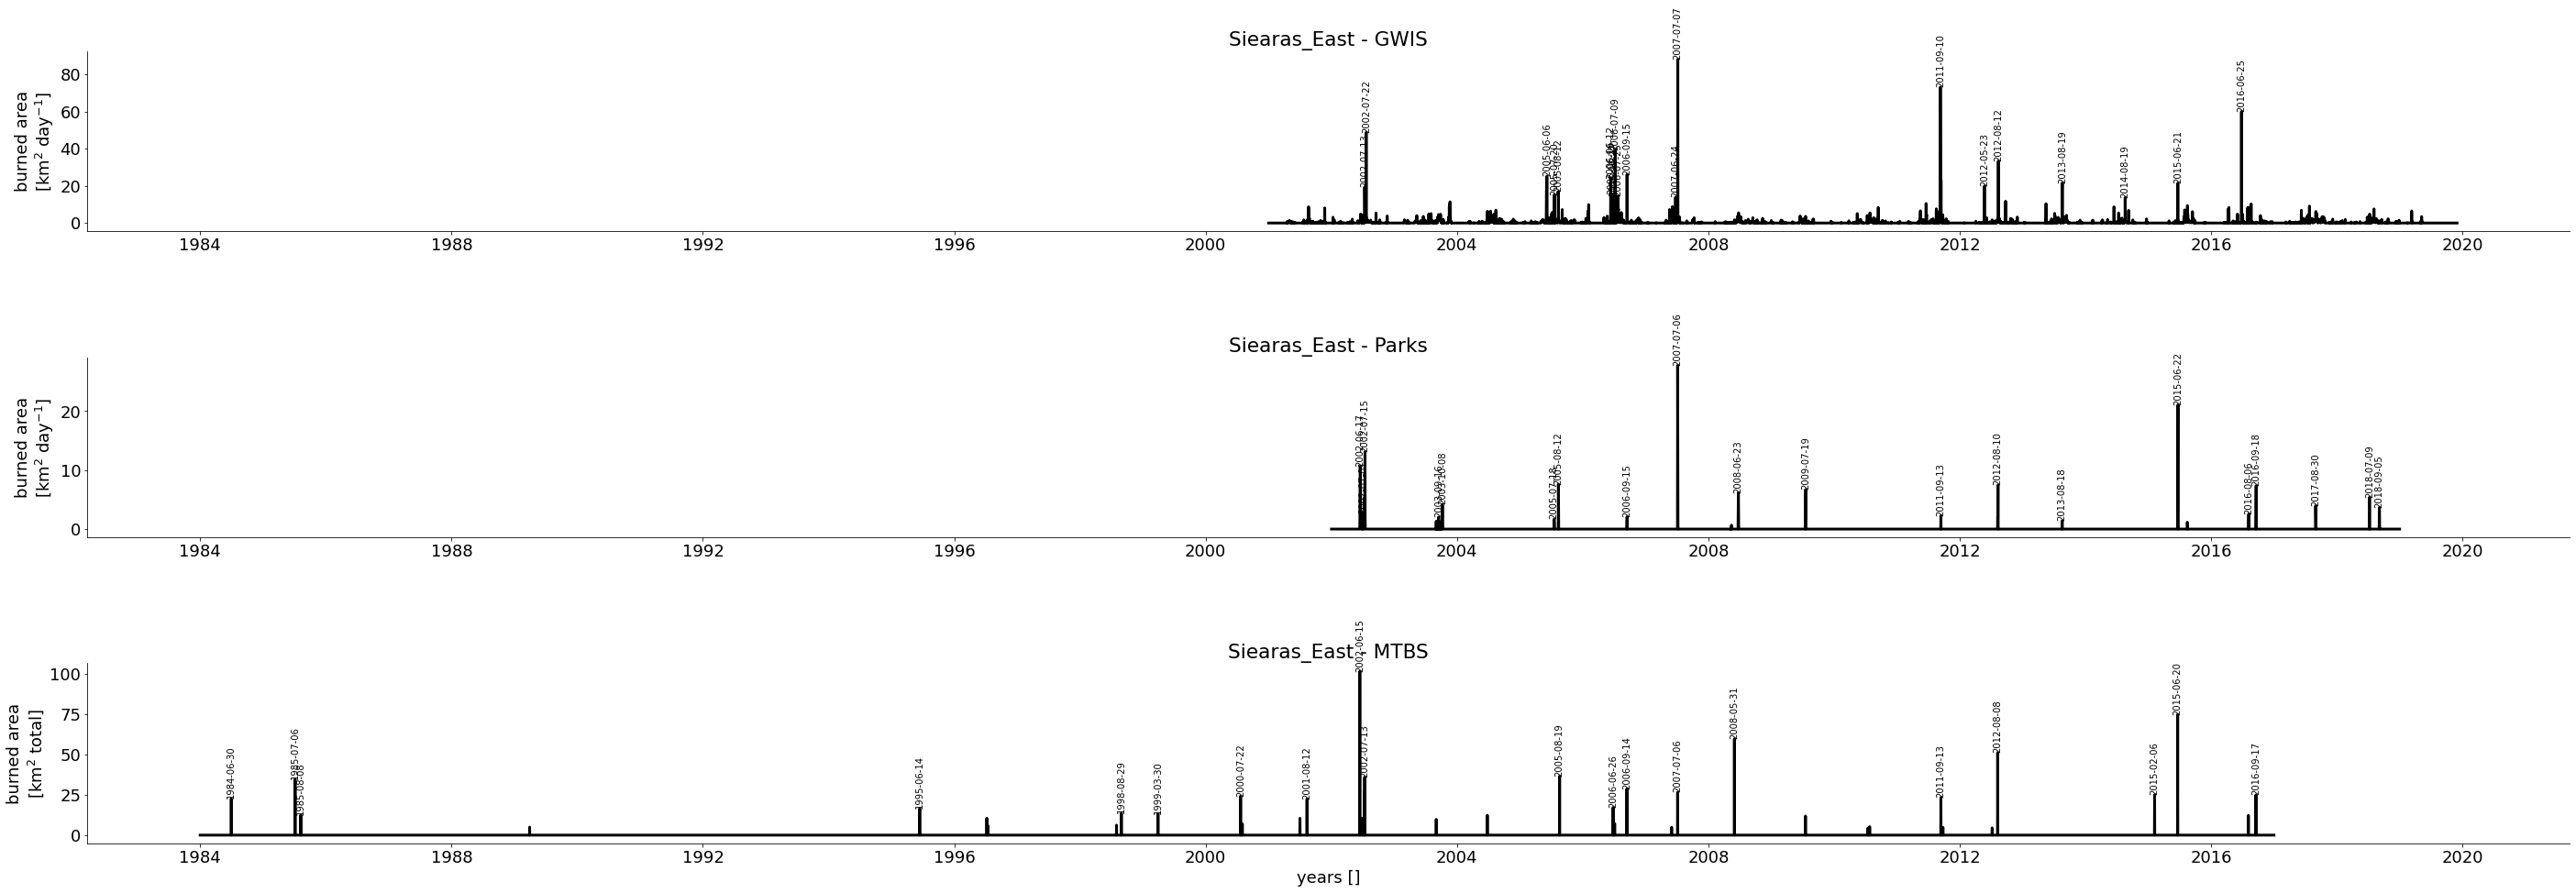

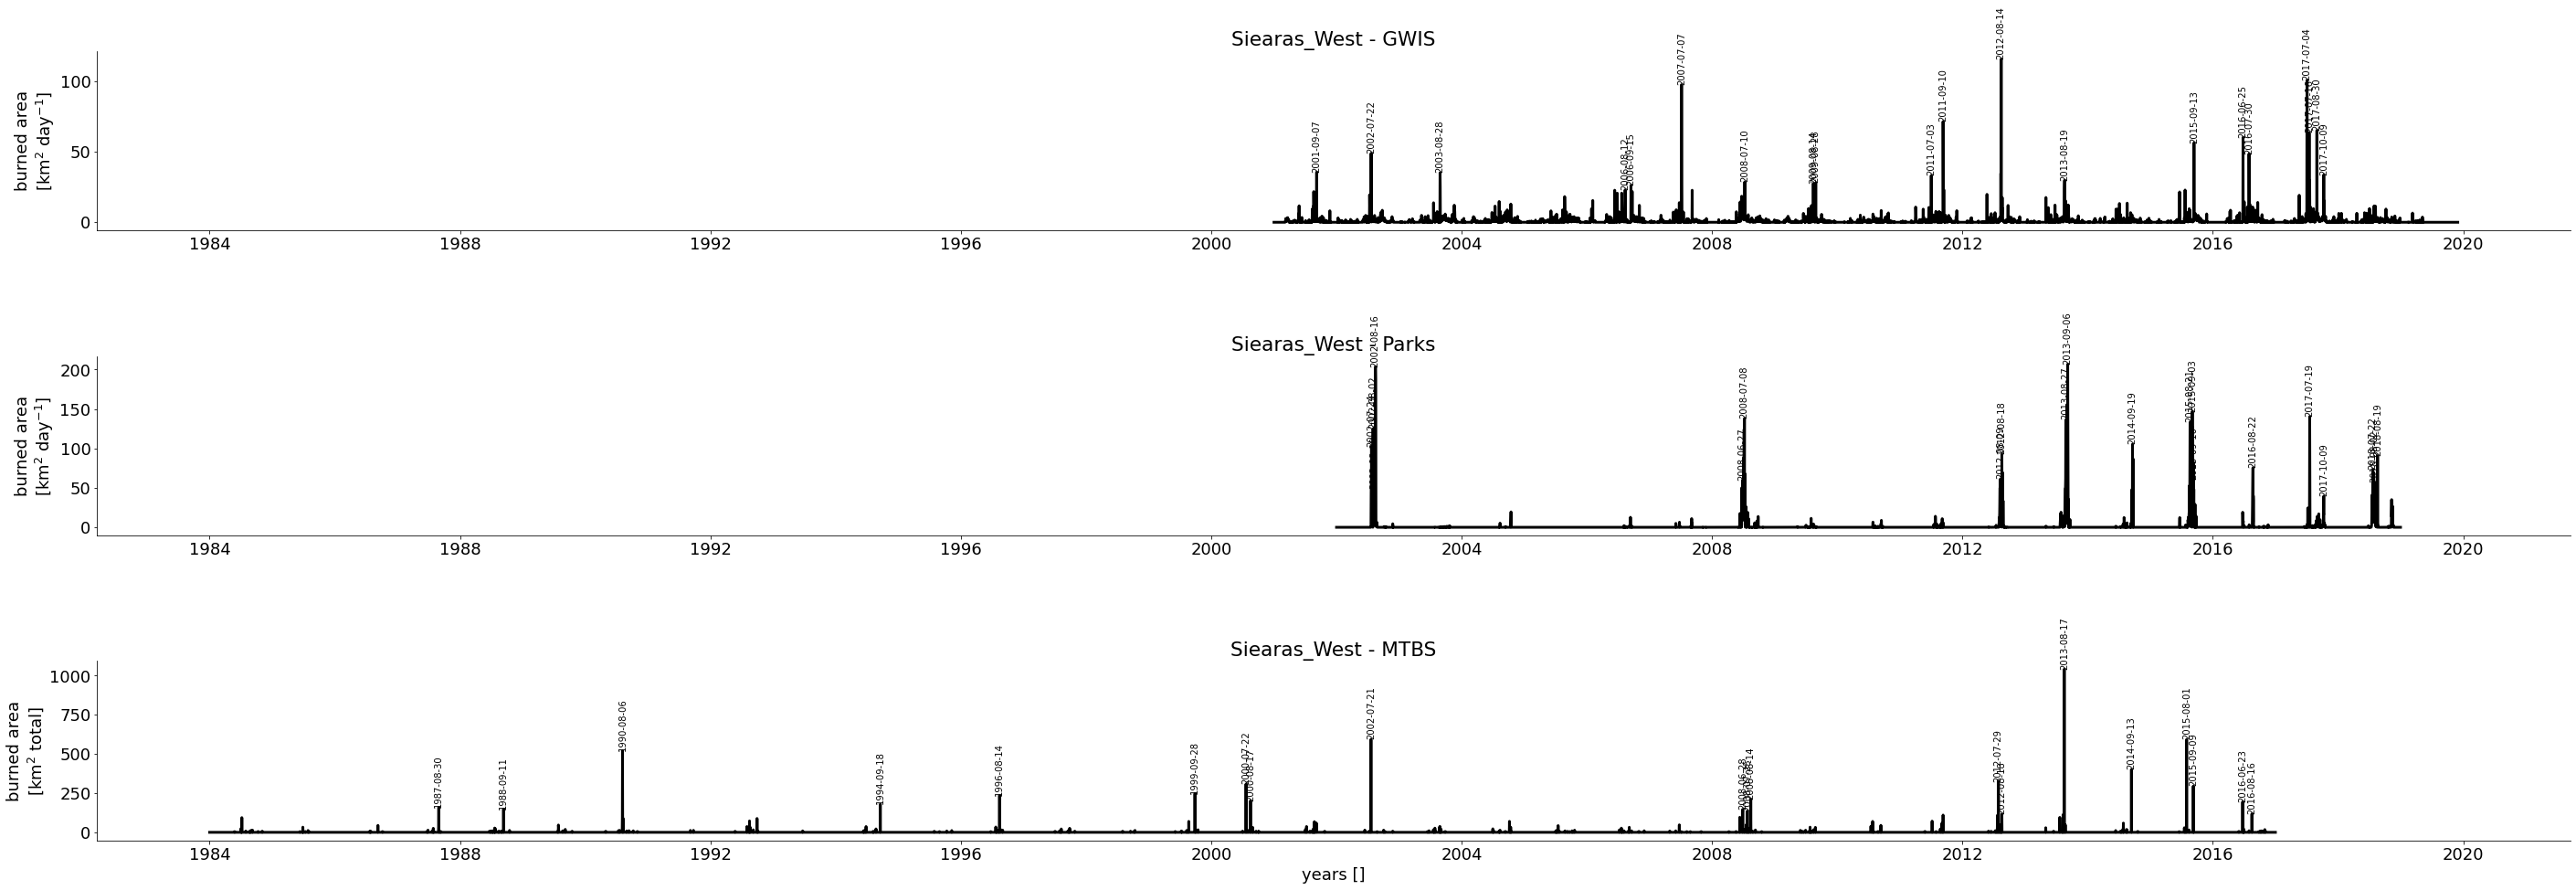

In [30]:
# join data into common matrix
for sr in range(len(CA_Regions)):
    StartTime=datetime.datetime(1984, 1, 1)  #Y-M-D --> days are smallest possible period
    StopTime=datetime.datetime(2019, 11, 30)
    rgdTimeALL = pd.date_range(StartTime, end=StopTime, freq='d')
    DATA_all=np.zeros((len(rgdTimeALL),3)); DATA_all[:]=np.nan
    SelTime=((rgdTimeALL.year >= rgdTimeMODIS.year[0]) & (rgdTimeALL.year <= rgdTimeMODIS.year[-1]))
    DATA_all[SelTime,0]=MODIS_SRdata[:,sr]
    SelTime=((rgdTimeALL.year >= rgdTimeParks.year[0]) & (rgdTimeALL.year <= rgdTimeParks.year[-1]))
    DATA_all[SelTime,1]=Parks_SRdata[:,sr]
    SelTime=((rgdTimeALL.year >= rgdTimeMTBS.year[0]) & (rgdTimeALL.year <= rgdTimeMTBS.year[-1]))
    DATA_all[SelTime,2]=MTBS_SRdata[:,sr]
    DATA_all[0,:]=0; DATA_all[-1,:]=0

    Labels=['GWIS','Parks','MTBS']

    # save the data for use in other programs
    File=CA_Regions[sr]+'_Fire-Obs.npz'
    np.savez(File,
           DATA_all = DATA_all,
           rgdTimeALL = rgdTimeALL,
           sDataset = Labels)

    plt.rcParams.update({'font.size': 18})
    rgsLableABC=list(string.ascii_lowercase)
    fig = plt.figure(figsize=(40,15))
    gs1 = gridspec.GridSpec(3,1)
    gs1.update(left=0.05, right=0.99,
               bottom=0.10, top=0.90,
               wspace=0.05, hspace=0.70)

    for da in range(3):
        ax = plt.subplot(gs1[da,0])
        plt.plot(rgdTimeALL, DATA_all[:,da], c='k', lw = 3)

        # label three biggest days
        FIN=~np.isnan(DATA_all[:,da])
        iTTex=ExtremeDays(DATA_all[:,da][FIN],20,7)
        TopDates=rgdTimeALL[FIN][ExtremeDays(DATA_all[:,da][FIN],20,7)]
        for ex in range(len(iTTex)):
            plt.text(rgdTimeALL[FIN][iTTex[ex]], DATA_all[:,da][FIN][iTTex[ex]],\
                     str(TopDates[ex])[:10], va='bottom', ha='center', rotation=90, fontsize=10)
        if da < 2:
            ax.set_ylabel('burned area\n[km$^{2}$ day$^{-1}$]')
        else:
            ax.set_ylabel('burned area\n[km$^{2}$ total]')
        if da == 2:
            ax.set_xlabel('years []')
        plt.title(CA_Regions[sr]+' - '+Labels[da])

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    sPlotFile='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/Fire-Obs-Comparison/'
    sPlotName= 'Peak-Fire-Days_'+CA_Regions[sr]+'.pdf'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print( '        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName) #, dpi=700)
    # fig.savefig(sPlotFile+sPlotName, dpi=700)

In [17]:
TopDates

DatetimeIndex(['2003-10-26', '2017-12-05', '2016-08-17'], dtype='datetime64[ns]', freq=None)